# <!-- TITLE --> Unsupervised classification of sound units segmented from soundscapes
---
<!-- DESC --> Machine learning framework to perform unsupervised classification of sound units segmented from soundscapes
<!-- AUTHOR --> : Sylvain Haupert and Juan Ulloa

### Objectives :
 - Providing a script to analyze soundscapes on a GoogleDrive
 - Testing a method to rapidly screen the acoustic content in soundscapes

The goal is to provide a workflow to process soundscapes coming from different recorders set in a tropical rain forest for 24h.

### What we're going to do :

*   Installing Bambird
*   Running Bambird on a dataset
*   Checking the clusters and compare them with a library of sounds produced by expected animals.

### Dataset :

The dataset is a collection of audio recordings from the project XPRIZE (Singapore). Each audio recording lasts 30 min, and they were recorded all day long during the entire May 2022

In this script, you will use the package bambird (more specificaly some functions from bamscape that contains the functions to analyse soundscapes).


## Step 1 - Setup the environment
---

Get the information about the virtual machine that Google gave you

In [78]:
# get info about the virtual machine
!lscpu |grep 'Model name'
!lscpu |grep 'Core(s) per socket:'
!free -h --si | awk  '/Mem:/{print $2}'

Model name:                         13th Gen Intel(R) Core(TM) i7-13700H
Core(s) per socket:                 14
63G


## 1.1 Global settings

Change or adapt the settings :
- to import the required packages
- to set the directories and the paths
- to set some global constatns
- to set the parameters for bambird

In [79]:
# Load basic packages
# --------------------
import shutil
import numpy as np
from pathlib import Path
import os
import datetime
import yaml
import sys
from glob import glob
from tqdm import tqdm

# scikit-learn (machine learning) package
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

from scipy.signal.windows import tukey

# notebook display
from IPython.display import clear_output # to clear output of jupyter cell

# pandas
import pandas as pd

# import the custom packages
#----------------------------
import maad
import bambird

# Parallel processing packages
from concurrent import futures



**WARNING** Adapt the paths to your local configuration

In [80]:
# Define constants
# ----------------

# directory where to store the data 
# !!! NEED TO BE ADAPTED TO YOU OWN CONFIG !!!
PROJECT_PATH    = Path('/media/haupert/data/mes_projets/05_xprize/final')

# !!! NEED TO BE ADAPTED TO YOU OWN CONFIG !!!
# ARCHIVE_PATH    = Path('/media/haupert/data/mes_projets_data/xprize/french_guiana_july_ground')
ARCHIVE_PATH    = Path('/media/haupert/data/mes_projets_data/xprize/canopy_station')

# !!! NEED TO BE ADAPTED TO YOU OWN CONFIG !!!
PACKAGE_PATH = Path('/media/haupert/data/mes_projets/_packages/bamscape.git')

DATA_PATH = PROJECT_PATH / Path('DATASETS_MAAD')
SAVE_PATH = PROJECT_PATH / Path('RESULTS_MAAD')

# subdirectories where to store the dataset and the extracted rois
DATASET_NAME    = ARCHIVE_PATH.stem + '_all'
ROIS_NAME       = Path(str(DATASET_NAME) +'_ROIS')

# subsample the dataframe containing all the audio recordings
EVERY_N_ROWS = 1 # Set to 1 to keep all files.

# audio file extension
AUDIO_EXTENSION = 'WAV'

# Select the configuration file to segment, compute features and get the clusters
CONFIG_FILE     = 'config_soundscape_maad.yaml'

EXTRACT_FEATURES = True

# Load the configuration file
# -----------------------------
params = bambird.load_config(PACKAGE_PATH / "src/bambird" / CONFIG_FILE)

# select the ROIs with SNR higher than SNR_HLIM
SNR_HLIM = 16           #@param {type:"slider", min:0, max:90, step:1}

# select the ROIs with centroid frequency between CENTROID_FREQ_LLIM and CENTROID_FREQ_HLIM (in Hz)
CENTROID_FREQ_HLIM = 20000 
CENTROID_FREQ_LLIM = 0

use the function <bambird.extract_rois_in_soundscape> to segment ROIS


## 1.3 Define some local functions

In [81]:
# %%
def date_from_filename (filename) :
    # filename with format 'XXXX_yyyymmdd_hhmmss.wav'
    # extract year, month, day, hour, minute and second from the filename
    # notice the underscore _ which splits the filename into several parts
    year = int(filename.split('_')[1][0:4])
    month = int(filename.split('_')[1][4:6])
    day = int(filename.split('_')[1][6:8])
    hour = int(filename.split('_')[2][0:2])
    minute = int(filename.split('_')[2][2:4])
    #second = int(filename.split('_')[2][4:6])
    second = 00

    # create a datetime object from the extracted parameters
    date = datetime.datetime(year, month, day, hour, minute, second)

    return date

def diffcumspec(spec1, spec2):
    
    s1 = spec1[:, 1] if spec1.ndim == 2 and spec1.shape[1] == 2 else spec1
    s2 = spec2[:, 1] if spec2.ndim == 2 and spec2.shape[1] == 2 else spec2
    
    n1 = len(s1)
    n2 = len(s2)
    
    if n1 != n2:
        raise ValueError("spec1 and spec2 must have the same length")
    
    if np.isnan(s1).any() or np.isnan(s2).any():
        D = np.nan
        print("The data set contains 'NA' values. The returned values have been set to NA.")
        return D
    else:
        if np.any(s1 < 0) or np.any(s2 < 0):
            raise ValueError("spectra (spec1 and/or spec2) do not have to be in dB")
        
        if np.sum(s1) == 0:
            print("Caution!, spec1 is a null spectrum")
        
        if np.sum(s2) == 0:
            print("Caution!, spec2 is a null spectrum")
        
        s1 = s1 / np.sum(s1)
        s2 = s2 / np.sum(s2)
        
        cum_s1 = np.cumsum(s1)
        cum_s2 = np.cumsum(s2)
        
        D = np.sum(np.abs(cum_s1 - cum_s2)) / n1

    return D

# %%
def find_representative_samples (df_cluster):
            
    # copy
    df = df_cluster.copy()

    # set cluster_number as the index
    # df.set_index("cluster_number", inplace = True)

    # convert the features to numpy array
    df['features'] = df['features'].apply(lambda x: np.array(x))
    
    # dataframe with the average features of each cluster
    df_avg = pd.DataFrame({'features' : df.groupby('cluster_number')['features'].apply(np.mean)})
    
    # dataframe with the nearest samples to the center of each cluster
    df['dist_likeness'] = np.nan
    df['normdist'] = np.nan
    df['dist'] = np.nan
    df['cosine_likeness'] = np.nan
    df['cosine'] = np.nan
    df['model'] = 0
    
    for index, y in df_avg.iterrows():  

        # if noise, continue
        if index == -1 :
            continue
        
        # variables
        y = y.features  # average features
        X = np.array(df[df.cluster_number == index].features.tolist()) # all the features of the cluster

        # distance
        neighbors = NearestNeighbors(n_neighbors=len(X))
        neighbors_fit = neighbors.fit(X)
        distances, index_sample = neighbors_fit.kneighbors([y])       
        d = distances[0]

        # angle
        a = cosine_similarity(X, y.reshape(1,-1)).flatten()
        
        # Give an indicator of the likeness of the sample regarding its cluster
        #-------------------------------------------------------------------------
        # 1 is the closest sample to the model (the most likeness of the cluster)
        # 0.5 is as half the distance between the furthest and the closest
        # 0 is the furthest sample (should be very different to the avg sample)
        df.update(pd.DataFrame({'dist_likeness': 1-(d-min(d))/(max(d)-min(d))},
                                index =  df[df.cluster_number == index].iloc[index_sample[0]].index ))
        # normalized distance
        # 1 is the closest to the model 
        # 2 is twice the distance to the model
        # 10 is ten times the minimum distance to the model
        df.update(pd.DataFrame({'normdist': d/d[0]},
                                index =  df[df.cluster_number == index].iloc[index_sample[0]].index ))
        # absolute distance
        d = distances[0]
        df.update(pd.DataFrame({'dist': d},
                                index =  df[df.cluster_number == index].iloc[index_sample[0]].index ))
        # similarity (cosine)
        # 1 both vectors are colinear (the angle is 0°)
        # 0 both vectors are orthogonal (the angle is 90°)
        df.update(pd.DataFrame({'cosine': a},
                                index =  df[df.cluster_number == index].iloc[index_sample[0]].index ))
        # 1 is the closest sample to the model (the most likeness of the cluster)
        # 0.5 is as half the angle between the furthest and the closest
        # 0 is the furthest sample (should be very different to the avg sample)
        df.update(pd.DataFrame({'cosine_likeness': (a-min(a))/(max(a)-min(a))},
                                index =  df[df.cluster_number == index].iloc[index_sample[0]].index ))

        # df_cluster_per_file['features'] = df_cluster_per_file['features'].apply(lambda x: np.array(x))
        # # Compute the silhouette scores for each sample
        # X = np.array(df_cluster_per_file.features.tolist())
        # silhouette = silhouette_samples(X, df_cluster_per_file['cluster_number'])
        # df_cluster_per_file['silhouette'] = silhouette

        # add a column "model"
        # 1 => the closest to the average features = model, 0 either.        
        idx = df[df.cluster_number == index].iloc[index_sample[0][0]].name
        df.at[idx,'model'] = 1

    return df

# %%
def select_cluster_percentile (
                            df_cluster,
                            column      = "cluster_number",
                            percentile  = 75,
                            remove_noise= True
                            ) :
    # Count the number of ROIs per cluster and select the first "percentile" of
    # cluster, from the biggest (percentile = 1) to the smallest (percentile = 99)
    # Does not take into account the cluster "noise" (=-1)

    # copy the dataframe
    df = df_cluster.copy()

    # clean df_cluster by removing the noise : -1
    if remove_noise :
        df = df[df[column] >-1]

    # count the number of each value
    counts = df[column].value_counts()

    # sort counts value from the highest count to the lowest
    counts = counts.sort_values(ascending=False)

    # select the vector of id
    cumulative = counts.cumsum() / counts.sum()
    mask = cumulative > (percentile / 100)
    idx = cumulative[mask].index[0]
    selected = counts.loc[:idx]

    # filter the dataframe to keep only the biggest clusters
    df = df[df[column].isin(selected.index)]

    return df

def copy_matching_files(source_dir, 
                        destination_dir, 
                        pattern="*"):
    """
    Copies files matching a pattern from source directory to destination directory.

    Args:
        source_dir: Path to the source directory.
        destination_dir: Path to the destination directory.
        pattern: Glob pattern to match files (default: "*").
    """
    from glob import glob
    
    source_dir = Path(source_dir)
    destination_dir = Path(destination_dir)

    # Get all matching files as Path objects
    matching_files = glob(str(source_dir / pattern), recursive=True)
    matching_files = [Path(file) for file in matching_files]

    # Create destination directory if it doesn't exist
    if not destination_dir.exists():
        destination_dir.mkdir()

    # Copy each matching file
    for file in matching_files:
        relative_path = file.relative_to(source_dir)
        dest_file = destination_dir / relative_path
        dest_file.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(file, dest_file)

def extract_roi (filename, min_t, max_t, min_f, max_f, margins=None, normalize=False, save_path=None):
    """
    create a function that open an audio file and extract a roi
    
    Parameters
    ----------
    filename : str
        path to the audio file
    min_t : float
        start time of the roi in seconds
    max_t : float
        end time of the roi in seconds
    min_f : float
        start frequency of the roi in Hz
    max_f : float
        end frequency of the roi in Hz
    margins : list  (default None)
        margins to add to the roi (time, frequency) in seconds and Hz
    save_path : str (default None)
        path to save the roi
    """
    
    # open the audio file
    s, fs = maad.sound.load(filename)

    # duration
    duration = len(s) / fs

    if margins is not None :
        min_t = max(0.0, min_t - margins[0])
        max_t = min(duration, max_t + margins[0])
        min_f = max(1, min_f - margins[1])
        max_f = min(fs/2, max_f + margins[1])

    # extract the roi
    roi = maad.sound.trim(s, fs, min_t, max_t)
    roi = maad.sound.select_bandwidth(roi, fs, fcut=[min_f, max_f], forder=1, ftype='bandpass')
    # fade in and fade out roi
    # create a tukey window of 1% of the roi duration
    win = tukey(roi.size, alpha=0.01)
    roi = roi * win

    # normalization
    if normalize:
        roi = maad.sound.normalize(roi)
    
    # save the roi
    if save_path is not None:
        # test if the parent directory exists
        if not os.path.exists(os.path.dirname(save_path)):
            os.makedirs(os.path.dirname(save_path))
        # save the roi
        maad.sound.write(filename=save_path, fs=fs, data=roi, bit_depth=16)
    
    return roi


## Step 2 - Data processing
---

Load the configuration file. In case of soundscapes, the file ***config_soundscape.yaml*** works well for most soundscapes. Of course you can also edit the file and adapt the parameters to your need.

## 2.1 Grab and prepare audio

In [82]:
# Grab audio
# -------------------
df = maad.util.date_parser(ARCHIVE_PATH, dateformat='%Y%m%d_%H%M%S', extension='.'+AUDIO_EXTENSION, prefix = '', verbose=False)

# rename the column file into fullfilename
df.reset_index(inplace=True)

# rename the column file into fullfilename
df.rename(columns={'file':'fullfilename'}, inplace=True)
df.rename(columns={'Date':'date'}, inplace=True)

# add a column with the filename without the full path
df['filename'] = df['fullfilename'].apply(lambda x: Path(x).name)

# print the number of audio recordings
print("The number of audio recordings is %d" %len(df))

The number of audio recordings is 235


**Subsamples the dataframe** in order to make quick tests

In [83]:
# Keep rows every N rows
df = df.iloc[::EVERY_N_ROWS, :]

# print the number of audio recordings
print("The number of audio recordings that will be processed is %d" %len(df))

The number of audio recordings that will be processed is 235


## 2.2 Extract ROIS

### 2.2.1 Try on a single file

*   First extract ROIS of a single file in order to see if the parameters are fine.
*   Display the SNR for each ROIS found in the audio file


CATEGORIES : canopy_station
NUMBER OF CHUNKS : 3

time resolution 0.011609977324263039s
frequency resolution 43.06640625s
BGN 26.65743637699873dB / SNR 3.171231808906043dB
BEFORE MERGING FOUND 103 ROIS 
=> AFTER MERGING FOUND 59 ROIS
=> number of ROIS after ploting 59
=> number of ROIS after ploting 59

time resolution 0.011609977324263039s
frequency resolution 43.06640625s
BGN 26.6574970468344dB / SNR 3.128190560499668dB
BEFORE MERGING FOUND 125 ROIS 
=> AFTER MERGING FOUND 55 ROIS
=> number of ROIS after ploting 55
=> number of ROIS after ploting 55

time resolution 0.011609977324263039s
frequency resolution 43.06640625s
BGN 26.657497304372622dB / SNR 3.4826517920325983dB
BEFORE MERGING FOUND 117 ROIS 
=> AFTER MERGING FOUND 62 ROIS
=> number of ROIS after ploting 62
=> number of ROIS after ploting 62


============== OVERLAY ROIS ON THE ORIGINAL FILE ==============

Display ROIs found in the file /media/haupert/data/mes_projets_data/xprize/canopy_station/20240303_025500.WAV
labels 

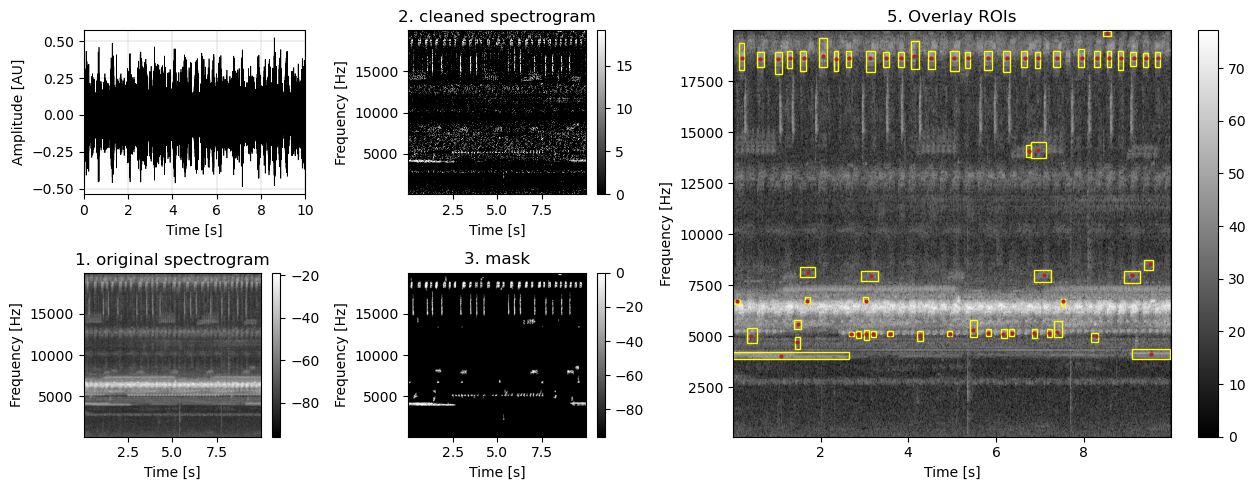

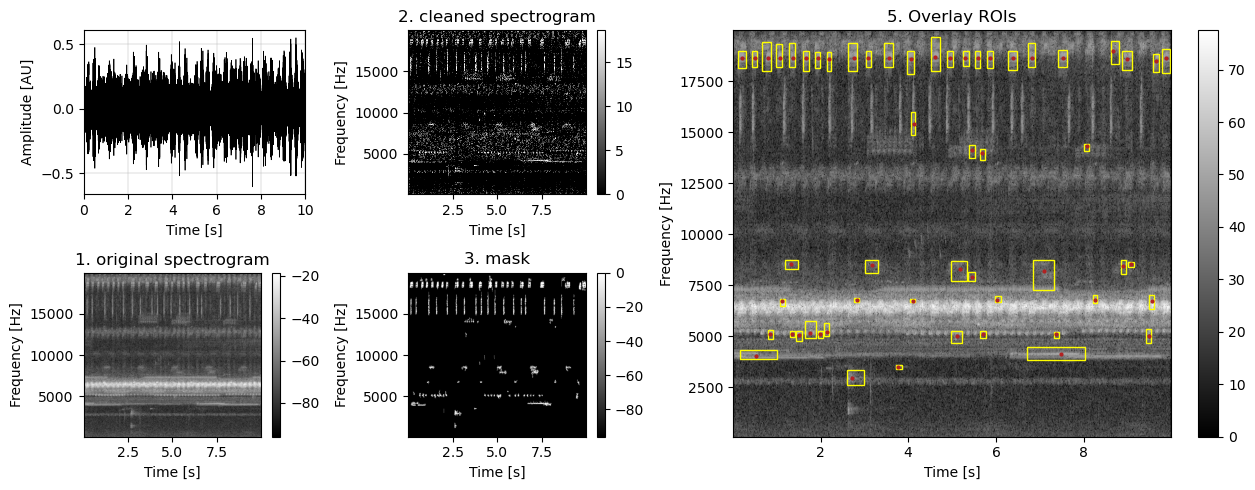

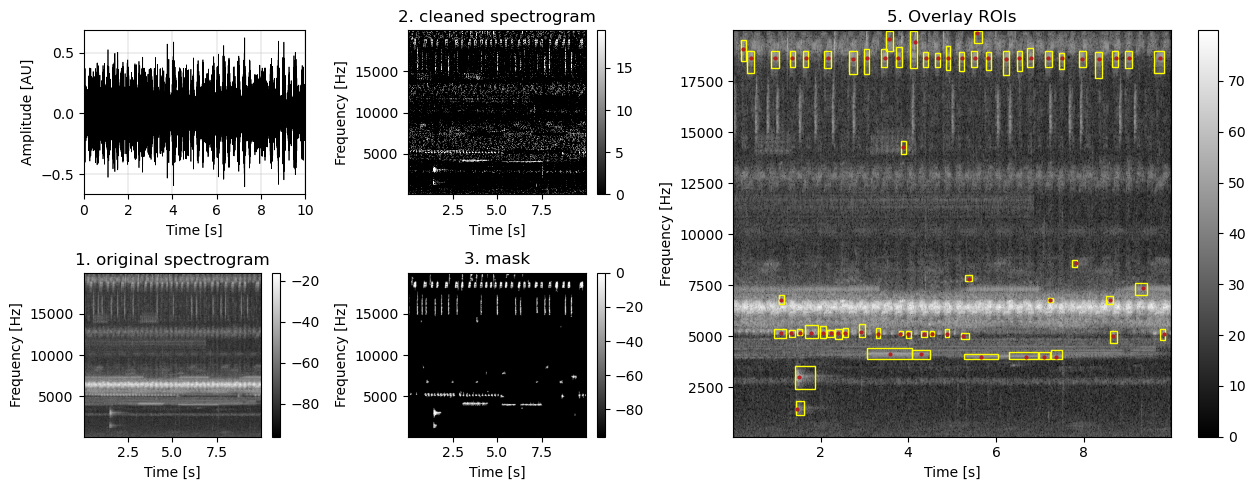

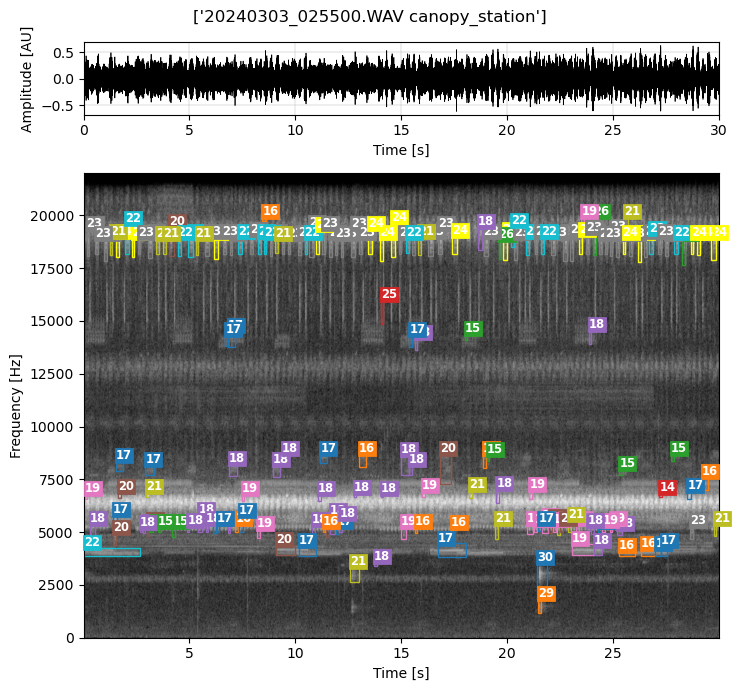

In [84]:
# Extract ROIS of a single file
# -------------------------------

# ROIS extraction of a single file
df_rois_single = bambird.single_file_extract_rois (
                    audio_path  = df.sample().fullfilename.squeeze(),
                    # audio_path  = ARCHIVE_PATH / '20240302_162500.WAV',  # if a specific file needs to be tested 
                    fun         = params['PARAMS_EXTRACT']['FUNC'],
                    params      = params['PARAMS_EXTRACT'],
                    save_path   = DATA_PATH / ROIS_NAME,
                    display     = True,
                    verbose     = True)

# and display the ROIs on the file
# convert the column snr into integer in order to use the value as a label for each ROI
# This is temporary, only on df_rois_single that will not be used after
if len(df_rois_single) > 0 : # test if there is at least a single ROI
  df_rois_single["snr"] = df_rois_single["snr"].apply(int)
  bambird.overlay_rois(
                      cluster         = df_rois_single,
                      params          = params['PARAMS_EXTRACT'],
                      column_labels   = 'snr', 
                      unique_labels   = np.sort(df_rois_single.snr.unique()),
                      filename        = None,
                      random_seed     = None,
                      verbose         = True
                      )
else :
  print("No ROI was found")

### 2.2.2 Extract all the ROIS

Extract all the ROIS. It takes about 1 min for 200 1 min audio files

In [85]:
# Extract ROIS
# -------------------------------

# ROIS extraction of the full dataset
df_rois, csv_rois = bambird.multicpu_extract_rois(
                    dataset     = df,
                    params      = params['PARAMS_EXTRACT'],
                    save_path   = DATA_PATH / ROIS_NAME,
                    overwrite   = True,
                    verbose     = True
                    )

print("{} rois were found".format(len(df_rois)))

======================= EXTRACT ROIS =========================

The directory /media/haupert/data/mes_projets/05_xprize/final/DATASETS_MAAD/canopy_station_all_ROIS already exists and will be overwritten
235 new files will be processed
Composition of the dataset : 
   -number of files :  8
   -number of categories :  1
   -unique categories : ['default']
<function extract_rois_in_soundscape at 0x78587599c550>


100%|██████████| 8/8 [00:01<00:00,  5.94it/s]




0 new ROIs added in /media/haupert/data/mes_projets/05_xprize/final/DATASETS_MAAD/canopy_station_all_ROIS
25435 rois were found


In [86]:
# find the audio file (filename) in df that are not in the dataframe df_rois
# this is useful to check if some files were not processed
df_missing = df[~df['filename'].isin(df_rois['filename'])]['filename']

print("The number of audio recordings that were not processed is %d / %d" %(len(df_missing), len(df)))
print("List of these audio files :")
display(df_missing)

The number of audio recordings that were not processed is 8 / 235
List of these audio files :


0     20240302_125000.WAV
43    20240302_162500.WAV
44    20240302_163000.WAV
45    20240302_163500.WAV
46    20240302_164000.WAV
47    20240302_164500.WAV
48    20240302_165000.WAV
55    20240302_172500.WAV
Name: filename, dtype: object

## 2.3 Compute features
It takes about an hour for about 80 000 ROIs

Hide cell ouput (https://pieriantraining.com/jupyter-notebook-output-suppression-a-tutorial/)
1. Select the cell whose output you want to hide.
2. Click on the Cell menu at the top of the screen.
3. Click on Cell Tags.
4. Enter “hide_output” (without quotes) in the input field.
5. Press Enter.

In [87]:
# # Compute features for each ROIS
# # -------------------------------

# compute the features on the full dataset
df_features, csv_features = bambird.multicpu_compute_features(
                dataset     = df_rois,
                params      = params['PARAMS_FEATURES'],
                save_path   = DATA_PATH / ROIS_NAME,
                overwrite   = True,
                verbose     = True)
    



====================== COMPUTE FEATURES ======================

Features already computed for 25435 audio files
No feature needs to be computed
>>> FEATURES COMPUTING PROCESS ABORTED <<<


# Step 3 - Clustering and display




## 3.1 Main clustering

Clustering's steps :

1. Select only ROIs with SNR higher than a threshold (SNR_HLIM). This will help to cluster only the "best" sound events
2. Select ROIs with frequency centroid between low and high limits in order to focus on avian (200Hz-8000Hz), amphibians (0Hz-5000Hz), insects (>4000Hz)...
3. Do the clustering (about 30s)
4. Overlay the clusters
5. Combine ROIs that belong to the same cluster and that are very close to each other in order to form new longer ROIs. This will reduce the number of ROIs to listen to and will help the experts for the identification


In [88]:
# Select ROIS with high SNR
#--------------------------------
df_features_selected = df_features[df_features.snr >= SNR_HLIM]
print("Keep {} ROIs with SNR >= {}dB over {}".format(len(df_features_selected), SNR_HLIM, len(df_features)))

Keep 23388 ROIs with SNR >= 16dB over 25435


In [89]:
# Select ROIS depending on the centroid frequency
#-------------------------------------------------
df_features_selected = df_features_selected[(df_features_selected.centroid_f <= CENTROID_FREQ_HLIM) & (df_features_selected.centroid_f >= CENTROID_FREQ_LLIM)]
print("Keep {} ROIs with centroid frequency between {}Hz and {}Hz".format(len(df_features_selected), CENTROID_FREQ_LLIM, CENTROID_FREQ_HLIM))


Keep 23388 ROIs with centroid frequency between 0Hz and 20000Hz


In [90]:
#  Cluster ROIS
# -------------------------------

# find the clusters by categories
df_cluster, csv_cluster = bambird.find_cluster(
                dataset = df_features_selected,
                params  = params['PARAMS_CLUSTER'],
                display = False,
                verbose = True
                )



====================== CLUSTER FEATURES ======================

______UMAP reduction
EPS is 0.055679484372620165
HDBSCAN eps 0.055679484372620165; min_samples 40; min core samples 5; Number of soundtypes found for canopy_station : 80; 94.61898721826519% are clustered


### 3.1.1 Overlay ROIs



============== OVERLAY ROIS ON THE ORIGINAL FILE ==============

Display ROIs found in the file /media/haupert/data/mes_projets_data/xprize/canopy_station/20240302_221000.WAV
labels : [30 31 31 31 31 31 30 31 -1 31 31 31 31 25 25 25 25 25 25 25 25 25 25 25
 25 25 73 -1  9 58 27 58 59 59  8  8  8  8  8  8  8  8  5  5 18 18 18  4
 31 30 31 31 31 31 31 31 31 19 19 25 25 25 25 25 25 25 25 25 25 15 15 67
 71 53 53 35 54 58 58 58 59 59 59 -1 57 59 -1 27 57 63  8  8  8  8  8  8
  5  5 19 31 30 31 31 31 31 31 31 31 19 25 25 25 25 25 25 25 25 25 25 25
 25 25 15 15 15  9  9  9  9  9  9 -1 59 -1 -1 27 57 41  8  8  8  8  8  8
  5  5  5  5  5]


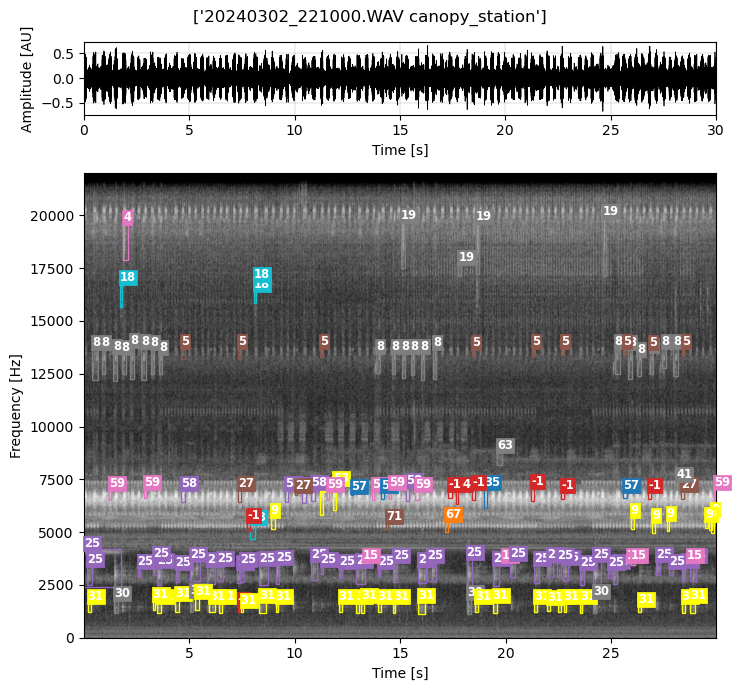

'20240302_221000.WAV'

In [91]:
# Display the ROIS
# -------------------------------

bambird.overlay_rois(
                    cluster         = df_cluster,
                    params          = params['PARAMS_EXTRACT'],
                    column_labels   = 'cluster_number', #auto_label cluster_number
                    unique_labels   = np.sort(df_cluster.cluster_number.unique()),
                    # filename        = '20240302_211000.WAV', # 20240302_131500 '20240303_023500.WAV', # S4A09128_20211011_033000 S4A09128_20211008_064500 S4A09128_20210211_043000 S4A09128_20211026_044500 S4A09128_20210603_074500 S4A09128_20210917_103000
                    random_seed     = None,
                    verbose         = True
                    )

### 3.1.2 Combinations

Combine ROIs from the same cluster that very close to each other 

In [92]:
df_combined = bambird.multi_cpu_combine_rois(
                                    df_cluster,
                                    remove_noise = True,
                                    params = params['PARAMS_CLUSTER'],
                                    verbose=False)

# number of rois after combining rois compare to the number of rois before
print("The number of ROIs before combining ROIs is %d" %len(df_cluster))
print("The number of ROIs after combining ROIs is %d" %len(df_combined))
print("The number of ROIs that were combined is %d" %(len(df_cluster) - len(df_combined)))


100%|██████████| 226/226 [00:14<00:00, 15.80it/s]

The number of ROIs before combining ROIs is 20498
The number of ROIs after combining ROIs is 8556
The number of ROIs that were combined is 11942




============== OVERLAY ROIS ON THE ORIGINAL FILE ==============

Display ROIs found in the file /media/haupert/data/mes_projets_data/xprize/canopy_station/20240303_000000.WAV
labels : [31 31 31 31 31 31 25 25 25 25 25 25 25 25 15 15 15 15 15 15 15 73 73 73
 75 9 9 35 35 59 59 27 27 27 27 27 8 8 8 8 0 0 0 0 0 19 19 19 26 26 26 57
 57 40 51 71 67 65 53 60 64 69]


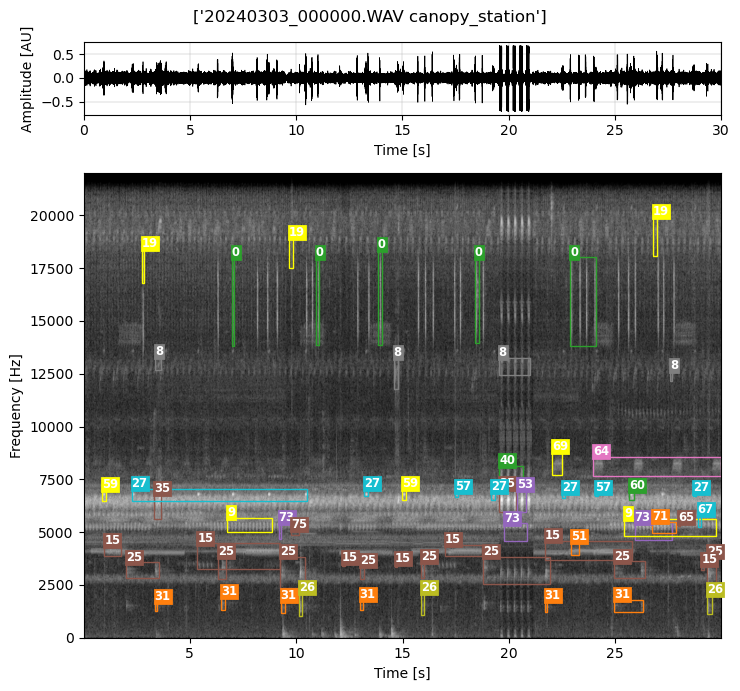

'20240303_000000.WAV'

In [93]:
# Display the ROIS
# -------------------------------

bambird.overlay_rois(
                    cluster         = df_combined,
                    params          = params['PARAMS_EXTRACT'],
                    column_labels   = 'cluster_number', #auto_label cluster_number
                    unique_labels   = np.sort(df_combined.cluster_number.unique()),
                    color_labels    = ['tab:green', 'tab:orange', 'tab:blue', 'tab:purple', 'tab:pink', 'tab:brown', 'tab:olive', 'tab:cyan', 'tab:gray', 'yellow'],
                    # filename        = '20240302_211000.WAV', # 20240302_152500 20240303_075500 '20240303_063500.WAV', #'20240303_023500.WAV', 
                    random_seed     = None,
                    verbose         = True)

## 3.2 Clustering of the noise only

1. Select the ROIs with the cluster number = -1
2. Change/ adapt the clustering parameters to the noise. For instance, the cluster size might be smaller as most of the sounds considered as noise are rare events.
3. Do the clustering (about 10s) and change the cluster number to negative number in order to distinguish the first "big" clusters to the second "smaller" clusters coming from "noise"
4. Overlay the clusters
5. Combine ROIs that belong to the same cluster and that are very close to each other in order to form new longer ROIs. This will reduce the number of ROIs to listen to and will help the experts for the identification


In [94]:
#  Cluster ROIS
# -------------------------------
# get the samples in df_cluster that are noise (cluster_number = -1) and then
# get the samples from index in df_cluster_noise in df_features_selected that are noise (cluster_number = -1)
df_features_noise = df_features_selected.loc[df_cluster[df_cluster.cluster_number == -1].index]

params_temp = params['PARAMS_CLUSTER'].copy()
params_temp['PERCENTAGE_PTS'] = None #0.2
params_temp['MIN_PTS'] = 40
params_temp['MIN_CORE_PTS'] = 5

# find the clusters by categories
df_cluster_noise, csv_cluster_noise = bambird.find_cluster(
                dataset = df_features_noise,
                # params  = params['PARAMS_CLUSTER'],
                params  = params_temp,
                save_csv_filename = 'cluster_noise.csv',
                display = False,
                verbose = True
                )

df_cluster_noise = df_cluster_noise.loc[df_cluster_noise[df_cluster_noise.cluster_number != -1].index]

# add +9000 to the cluster number of the noise to avoid confusion with the other clusters
df_cluster_noise['cluster_number'] = df_cluster_noise['cluster_number'].apply(lambda x: x+9000)



====================== CLUSTER FEATURES ======================

______UMAP reduction
EPS is 0.10397687748821086
HDBSCAN eps 0.10397687748821086; min_samples 40; min core samples 5; Number of soundtypes found for canopy_station : 13; 96.91749773345421% are clustered


### 3.2.1 overlay ROIs



============== OVERLAY ROIS ON THE ORIGINAL FILE ==============

Display ROIs found in the file /media/haupert/data/mes_projets_data/xprize/canopy_station/20240303_003000.WAV
labels : [9001 9007 9008 9008 9008 9006 9007 9008 9008 9008 9002 9001 9008]


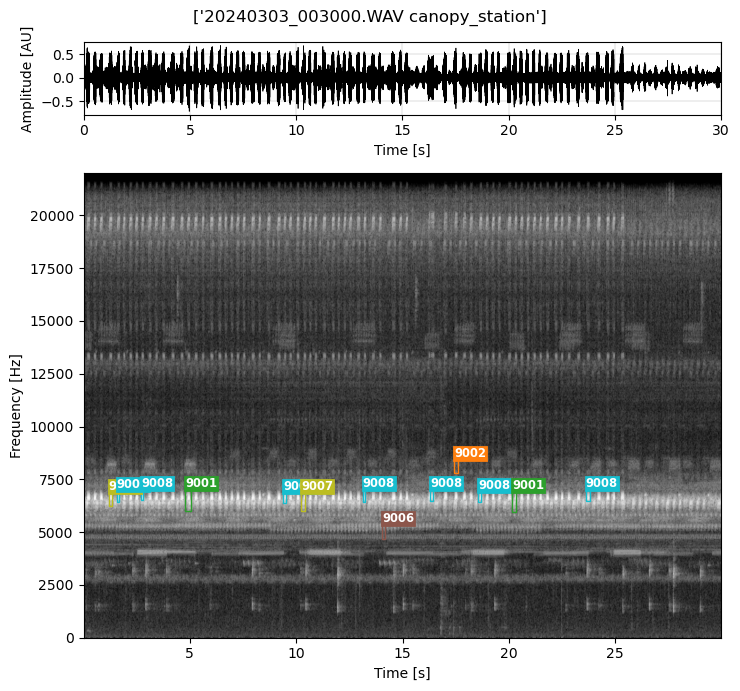

'20240303_003000.WAV'

In [95]:
# Display the ROIS
# -------------------------------
bambird.overlay_rois(
                    cluster         = df_cluster_noise,
                    params          = params['PARAMS_EXTRACT'],
                    column_labels   = 'cluster_number', #auto_label cluster_number
                    unique_labels   = np.sort(df_cluster_noise.cluster_number.unique()),
                    # filename        = '20240302_211000.WAV', # 20240303_074000.WAV 20240302_130000
                    random_seed     = None,
                    verbose         = True
                    )

### 3.2.2 Combinations

In [96]:
df_combined_noise = bambird.multi_cpu_combine_rois(
                                    df_cluster_noise,
                                    remove_noise = True,
                                    params = params['PARAMS_CLUSTER'],
                                    verbose=False)

# number of rois after combining rois compare to the number of rois before
print("The number of ROIs before combining ROIs is %d" %len(df_cluster_noise))
print("The number of ROIs after combining ROIs is %d" %len(df_combined_noise))
print("The number of ROIs that were combined is %d" %(len(df_cluster_noise) - len(df_combined_noise)))


100%|██████████| 196/196 [00:01<00:00, 142.06it/s]

The number of ROIs before combining ROIs is 1069
The number of ROIs after combining ROIs is 846
The number of ROIs that were combined is 223




============== OVERLAY ROIS ON THE ORIGINAL FILE ==============

Display ROIs found in the file /media/haupert/data/mes_projets_data/xprize/canopy_station/20240303_040500.WAV
labels : [9008 9008 9008 9010 9009 9011]


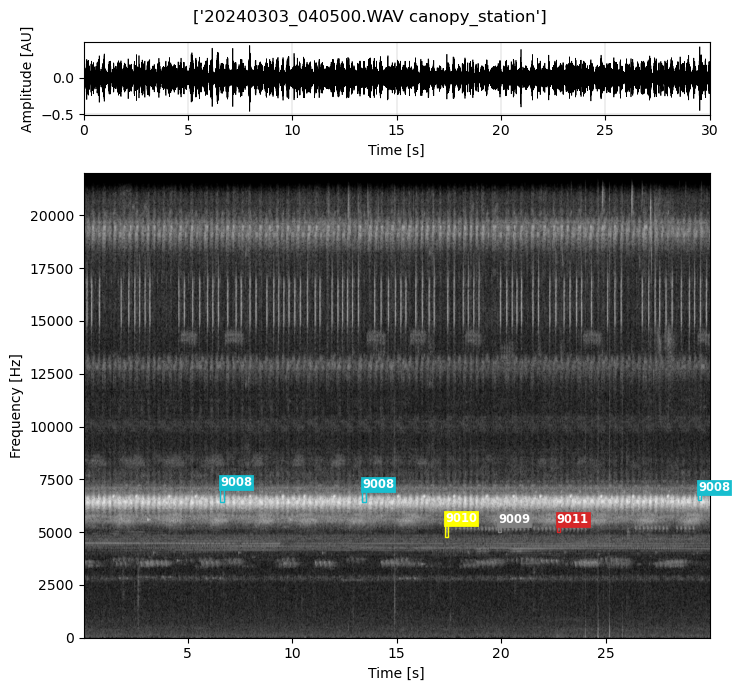

'20240303_040500.WAV'

In [97]:
# Display the ROIS
# -------------------------------

bambird.overlay_rois(
                    cluster         = df_combined_noise,
                    params          = params['PARAMS_EXTRACT'],
                    column_labels   = 'cluster_number', #auto_label cluster_number
                    unique_labels   = np.sort(df_cluster_noise.cluster_number.unique()),
                    # filename        = '20240302_211000.WAV', # 20240302_161000 20240303_063500 20240303_075500 '20240303_063500.WAV', #'20240303_023500.WAV', # S4A09128_20211011_033000 S4A09128_20211008_064500 S4A09128_20210211_043000 S4A09128_20211026_044500 S4A09128_20210603_074500 S4A09128_20210917_103000
                    random_seed     = None,
                    verbose         = True
                    )

## 3.3 Combine cluster and cluster with noise

### 3.3.1 Combination



============== OVERLAY ROIS ON THE ORIGINAL FILE ==============

Display ROIs found in the file /media/haupert/data/mes_projets_data/xprize/canopy_station/20240303_063500.WAV
labels : [24 24 24 24 63 52 52 52 52 52 52 16 12 12 12 29 29 29 25 25 25 25 25 9 9
 9 15 15 15 15 15 15 44 44 44 44 47 47 46 46 46 46 46 51 51 51 51 51 67 67
 67 67 67 74 74 48 48 48 48 27 27 50 50 50 50 50 50 10 10 41 41 13 13 13
 70 70 70 70 5 45 28 32 62 62 42 21 20 49 9002 9002 9002 9002 9006]


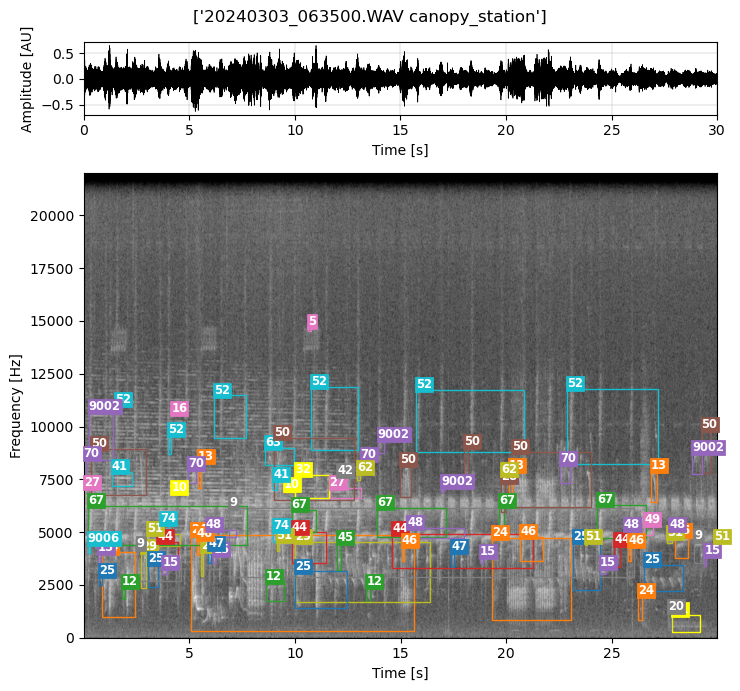

'20240303_063500.WAV'

In [104]:
# merge df_cluster and df_cluster_noise
df_combined_all = pd.concat([df_combined, df_combined_noise], ignore_index=True)

# Display the ROIS
# -------------------------------

bambird.overlay_rois(
                    cluster         = df_combined_all,
                    params          = params['PARAMS_EXTRACT'],
                    column_labels   = 'cluster_number', #auto_label cluster_number
                    unique_labels   = np.sort(df_combined_all.cluster_number.unique()),
                    # filename        = '20240302_214500.WAV', # 20240302_205000 20240302_214500 20240302_161000 20240303_063500 20240303_075500 '20240303_063500.WAV', #'20240303_023500.WAV', # S4A09128_20211011_033000 S4A09128_20211008_064500 S4A09128_20210211_043000 S4A09128_20211026_044500 S4A09128_20210603_074500 S4A09128_20210917_103000
                    random_seed     = None,
                    verbose         = True
                    )


### 3.3.2 Display the Rois of a single cluster

* Select the cluster number that you want to display
* Loop over the clusters with the selected number to display their spectrogram

In [22]:
NN = -95
for idx, row in df_combined_all[df_combined_all.cluster_number == NN].iloc[0:10].iterrows():
    # open the audio file
    s, fs = maad.sound.load(row['fullfilename'])
    # trim the audio file
    s = maad.sound.trim(s, fs, row['min_t'], row['max_t'])
    # select the bandwidth
    s = maad.sound.select_bandwidth(s, fs, fcut=[row['min_f'], row['max_f']], forder=3, ftype='bandpass')
    # compute the spectrogram
    Sxx, tn, fn, ext = maad.sound.spectrogram(s, fs, nperseg=1024, noverlap=512)
    # display the spectrogram
    maad.util.plot_spectrogram(Sxx, fn, db_range=60, figsize=(1.5, 2), title=os.path.basename(row['fullfilename']))

## 3.4 Prepare clusters

1. Find representative samples and save dataframe
2. add columns and save the results in a csv

In [23]:
# Reorder the dataframe by cluster_number starting by the biggest size
# --------------------------------------------------------------------

df_cluster_combined = df_combined_all.copy()

# count the number of each cluster_number
counts = df_cluster_combined["cluster_number"].value_counts()

# sort counts value from the highest count to the lowest
counts = counts.sort_values(ascending=False)

# map the count to the cluster_number
df_cluster_combined['count'] = df_cluster_combined['cluster_number'].apply(lambda x: counts.get(x, str(-1)))

# Reorder the dataframe starting the highest number of clusters 
df_cluster_combined.sort_values(by='count', ascending=False, inplace=True)

Compute different metrics (cosine_likeness dist_likeness normdist) to estimate the likeness or the distance to the "centroid" of a cluster (= features of all ROIs that belongs to a cluster are averaged)

In [24]:
NUM_SAMPLES_BY_CLUSTER = 50
METRIC = 'dist' # normdist cosine dist (cosine_likeness dist_likenes : be carefull in this case the highest the better)

# find representative samples and save dataframe
#------------------------------------------------
df_cluster_repsamples = find_representative_samples(df_cluster_combined)

# select the top 50 samples per cluster
#----------------------------------------
# Group the dataframe by category and get the top 20 rows per category based on lowest normdist. Remove noise cluster (-1)
cols = ['cluster_number', 'count', 'filename_ts',  'fullfilename_ts', 'fullfilename','filename', 'min_t', 'max_t', 'min_f', 'max_f', METRIC, 'model', 'date','label'] 
cols = [x for x in cols if x in df_cluster_repsamples.columns]
df_cluster_selected = df_cluster_repsamples[cols].groupby('cluster_number').apply(lambda x: x.nsmallest(NUM_SAMPLES_BY_CLUSTER, METRIC) if len(x) >= NUM_SAMPLES_BY_CLUSTER else x)
# reset the index
df_cluster_selected.reset_index(drop=True, inplace=True)
# remove the noise cluster
df_cluster_selected = df_cluster_selected.loc[~ (df_cluster_selected.cluster_number==-1),:]

# test if the column date exists    
if 'date' in df_cluster_selected.columns:
    # cast the column date to datetime
    df_cluster_selected['date'] = pd.to_datetime(df_cluster_selected['date'])
    # add a column period with night (from 19h to 6h) dawn (from 6h to 9h) day (from 9h to 16h) and dusk (from 16h to 19h)
    df_cluster_selected['period'] = df_cluster_selected['date'].apply(lambda x: '1. night' if x.hour >= 19 or x.hour < 6 else '2. dawn' if x.hour >= 6 and x.hour < 9 else '3. day' if x.hour >= 9 and x.hour < 16 else '4. dusk')

# test if the column label exists
if 'label' in df_cluster_selected.columns:
    # rename the column label into suggested label
    df_cluster_selected.rename(columns={'label':'suggested_label'}, inplace=True)

# add columns for the group (insect, bird, bat, frog, noise, unknown), scientific_name, english_name, portugese_name
df_cluster_selected['group (insect, bird, bat, frog, noise, unknown)'] = ''
df_cluster_selected['scientific_name'] = ''
df_cluster_selected['english_name'] = ''
df_cluster_selected['portugese_name'] = ''

# reorder the columns
cols = ['cluster_number', 'filename_ts', 'period', 'suggested_label', 'group (insect, bird, bat, frog, noise, unknown)', 'scientific_name', 'english_name', 'portugese_name', 'count',  'model', 'date', 'fullfilename_ts', 'fullfilename','filename', 'min_t', 'max_t', 'min_f', 'max_f', METRIC]    
cols = [x for x in cols if x in df_cluster_selected.columns]
df_cluster_selected = df_cluster_selected[cols]
# reorder the dataframe by cluster_number and by period 
df_cluster_selected.sort_values(by=['cluster_number', 'period'], inplace=True)

# save the dataframe
#--------------------
filename = str(DATASET_NAME) + '_CLUSTERS_COMBINED.csv'
# test if the directory exists
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
df_cluster_selected.to_csv(SAVE_PATH / filename, index=False)

## 3.5 Save the ROIs in the folders corresponding to the cluster number

If a date is provided, the ROIs are saved in one of the 4 subfolder  corresponding to night / daw / day / dusk

In [25]:
# test the function extract_roi on a row of df_cluster_selected
incr = 0
for idx, row in df_cluster_selected.iterrows():
    # extrac the filename without the extension
    filename_ts = row['filename'].split('.')[0] + '_' + str(incr) + '.WAV'
    df_cluster_selected.loc[idx, 'filename_ts'] = filename_ts

    # test if the column date exists    
    if 'period' in df_cluster_selected.columns: 
        # create the fullfilename_ts path
        fullfilename_ts = str(SAVE_PATH / Path(str(DATASET_NAME) +  ('_CLUSTERS_COMBINED'))  / str(row['cluster_number']) / str(row['period']) / filename_ts)
    else:
        # create the fullfilename_ts path
        fullfilename_ts = str(SAVE_PATH / Path(str(DATASET_NAME) +  ('_CLUSTERS_COMBINED'))  / str(row['cluster_number']) / filename_ts)

    df_cluster_selected.loc[idx, 'fullfilename_ts'] = fullfilename_ts
    roi = extract_roi(
                row['fullfilename'], 
                row['min_t'], row['max_t'], row['min_f'], row['max_f'], 
                margins = [0.5, 500],
                normalize = True,
                save_path=fullfilename_ts)
    incr += 1

# save
filename = str(DATASET_NAME) + '_CLUSTERS_COMBINED.csv'
# test if the directory exists
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
df_cluster_selected.to_csv(SAVE_PATH / filename, index=False)

Select the metric and then display the most representative ROI of the cluster and then the random ROIs that are below or upper of a threshold

100%|██████████| 122/122 [01:52<00:00,  1.09it/s]


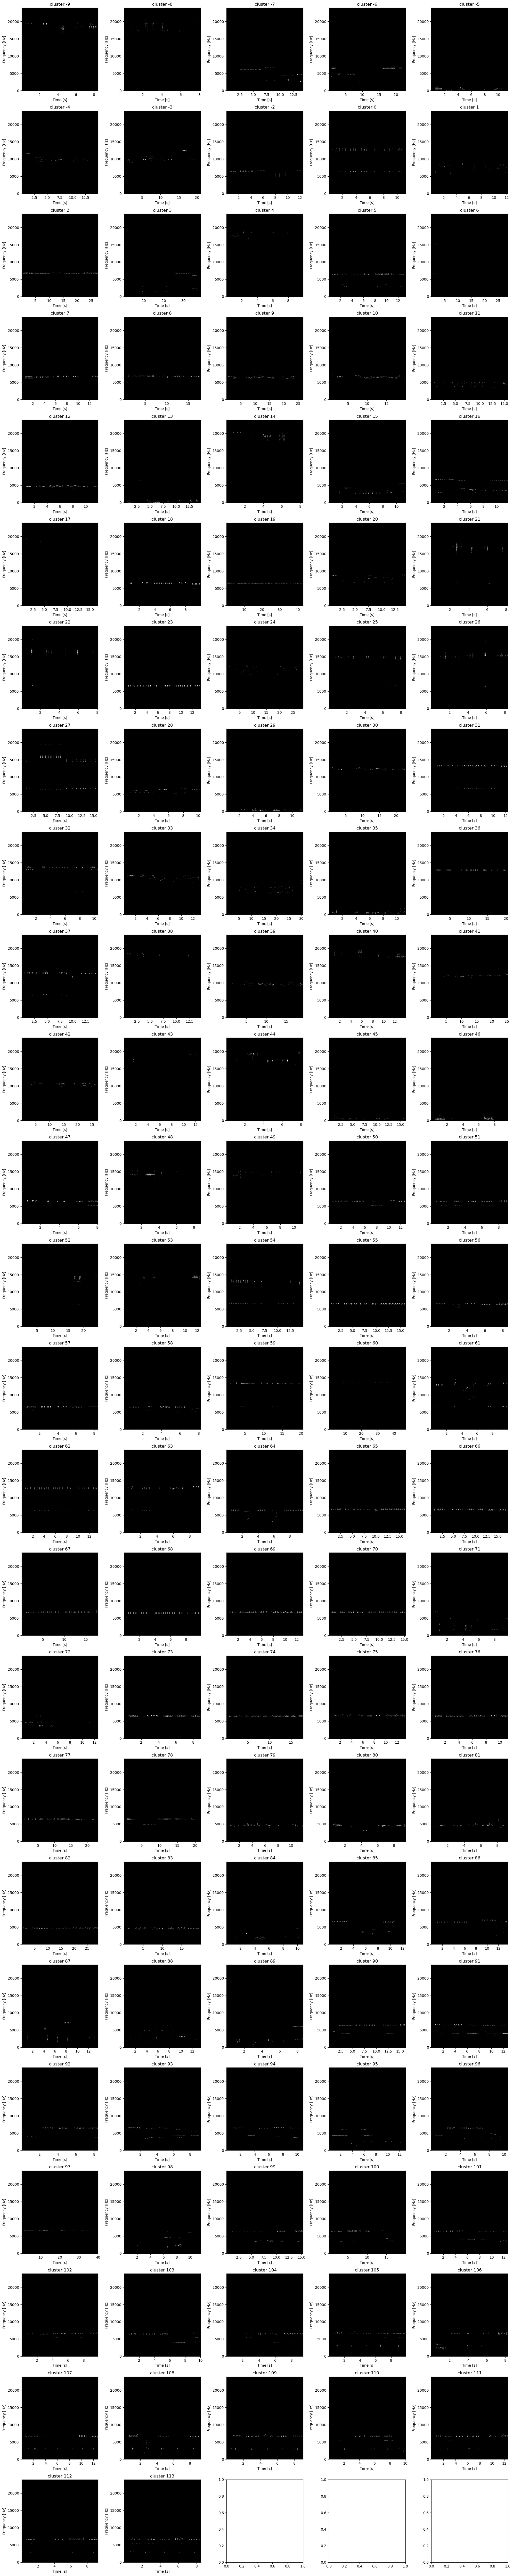

In [26]:
import matplotlib.pyplot as plt
from math import ceil
from scipy import signal
from tqdm import tqdm

# Create vignettes with the most representative ROIs for each cluster
#----------------------------------------------------------------------

# prepare the grid
columns = 5
rows = ceil(len(df_cluster_selected['cluster_number'].unique()) / columns)
fig, axes = plt.subplots(rows, columns, figsize = (20,20/columns*rows))

# Max number of samples by cluster
NUM_SAMPLES = 5

# initialize the counter
ii = 0

# 1. zero padding
#-----------------------------------------------------------------------
# get the fs
_, fs = maad.sound.load(df_cluster_selected.fullfilename_ts.values[0])

# create the vector of zero padding
duration = 0.5 # in seconds
sig0 = [0] * int(fs*duration)

# 2. load 5 audio for each cluster and concatenate them into a single audio
#-----------------------------------------------------------------------

for num in tqdm(df_cluster_selected['cluster_number'].unique()):

    sub_df = df_cluster_selected[df_cluster_selected['cluster_number'] == num]

    # Sort the dataframe by the value of the metric
    sub_df = sub_df.sort_values(by=METRIC)

    # Sample the rows. Get a maximum of NUM_SAMPLES rows. 
    # Could be less if the dataframe as less rows
    try :
        sub_df = sub_df.iloc[0:NUM_SAMPLES]
    except:
        print("less samples than the number required N={}".format(NUM_SAMPLES))

    # initialize an empty list
    sig = []

    for _ , row in sub_df.iterrows() :

        # load the audio
        sig1, fs = maad.sound.load(row.fullfilename_ts)
        # trim the audio
        # sig1 = maad.sound.trim(sig1, fs, min_t=0, max_t=(len(sig1)/fs)-CNN_MARGINS_T)
        # create a tukey window to avoid discontinuities
        window = signal.windows.tukey(len(sig1), alpha=0.05)
        # apply the window
        sig1 = (sig1 * window).tolist()

        # merge all sig with zero padding in between
        sig  += sig0 + sig1
    
    # list to array
    sig = np.asarray(sig)
    
    # Compute the spectrogram of the concatenate audio
    Sxx, tn, fn, ext = maad.sound.spectrogram(sig, fs, nperseg=1024)

    # Convert into dB from 0dB to 96dB maximum
    Sxx_dB = maad.util.power2dB(Sxx, db_range=96) + 96

    # Plot the spectrogram in the right subplot
    rr = ii // columns
    cc = ii - rr * columns
    maad.util.plot_spectrogram(Sxx_dB, extent=ext, 
                                # db_range=30, 
                                # gain=20, 
                                log_scale = False,
                                now = False,
                                title = 'cluster ' + str(num),
                                colorbar=False, ax=axes[rr, cc],
                                vmin=np.percentile(Sxx_dB,99), vmax=np.percentile(Sxx_dB,99.99))

    ii = ii +1

# 3. Save figure
#-----------------------------------------------------------------------
filename = str(DATASET_NAME) + '.pdf'
plt.savefig(SAVE_PATH /filename)
filename = str(DATASET_NAME) + '.png'
plt.savefig(SAVE_PATH /filename)

# Display
plt.show()